# Identifying voting pattern of U.S. senators for prediction and party affiliation identification

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [9]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pickle

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Style settings

In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In [4]:
np.random.seed(2018)

# Load a restricted set of votes
# This set contains ony the ones most easily interpretable for a person unfamiliar with american political matters
votes_restricted = pd.read_pickle("data/processed/processed_votes_1.pickle").dropna(0)
votes_restricted, _= split_dataframe(1, votes_restricted)
print("\n\n\nThe 1st vote dataframe is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(votes_restricted.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
print("\n\n\nBill descriptions is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(bill_descriptions.head(3))

# Load full set of votes, including motions
votes_full = pd.read_pickle("data/processed/processed_votes_2.pickle").dropna(0)
print("\n\n\nThe 2nd vote dataframe is a " + str(votes_full.shape) + " table with roll call ID as rows and description as columns.")
display(votes_full.head(3))

# Loads the selected senators details
senators = pd.read_pickle("data/processed/processed_senators.pickle")
senators = senators.loc[senators.index.intersection(votes_full.index)]
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

#Load labels
senators_party = senators['party']




The 1st vote dataframe is a (96, 23) table with senators as rows and vote positions as columns.


id,hr2-115-143-2,s722-115-147-1,sres584-115-162-2,hr1865-115-60-2,hr5515-115-128-2,s84-115-27-1,hr3364-115-175-1,hr2430-115-187-1,s2155-115-54-2,hconres71-115-245-1,...,sconres3-115-26-1,hr6157-115-193-2,sres176-115-138-1,s89-115-102-1,s2554-115-209-2,hr6147-115-180-2,treatydoc.114-12-115-98-1,hr5895-115-139-2,hr1-115-303-1,hr2810-115-199-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0





Bill descriptions is a (96, 23) table with senators as rows and vote positions as columns.


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The 2nd vote dataframe is a (96, 109) table with roll call ID as rows and description as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hconres71-115-245-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,...,sconres3-115-26-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1,sres176-115-138-1,sres584-115-162-2,treatydoc.114-12-115-98-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0





The senators dataframe is a (96, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.91,Lamar Alexander
B000575,R,Roy,Blunt,98.12,Roy Blunt
B000944,D,Sherrod,Brown,93.36,Sherrod Brown


## Building the similarity graph

In our graph, nodes represent senators and edges between senators indicate how similar they tend to vote on roll calls made on the senate floor. We have 96 senators for which we have a full congress worth of data and more than 100 different roll calls.

In [11]:
def build_graph(df):
    '''
    Builds the adjacency matrix by computing the similarities between senators.
    This implementation can be used to feed various features matrices and apply a different distance function and
    sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features
    '''
    features = df.values
    sparsification_function = lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .25), 20)
    adjacency = get_adjacency_multidistance(features, cosine_similarity, lambda x:x, sparsification_function)

    G= graphs.Graph(adjacency)
    G.compute_differential_operator()
    G.compute_fourier_basis()
    G.compute_laplacian()
    
    return adjacency,G

adjacency_restricted, G_restricted = build_graph(votes_restricted)
adjacency_full,G_full = build_graph(votes_full)

### Basic statistics about the graph

Clustering coefficient: 0.6431150038686803
Diameter: 6


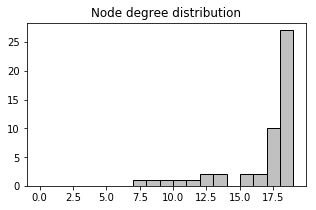

None


In [32]:
print(print_graph_specs(adjacency_full))

### Graph itself

Text(0.5,1,'Similarity graph')

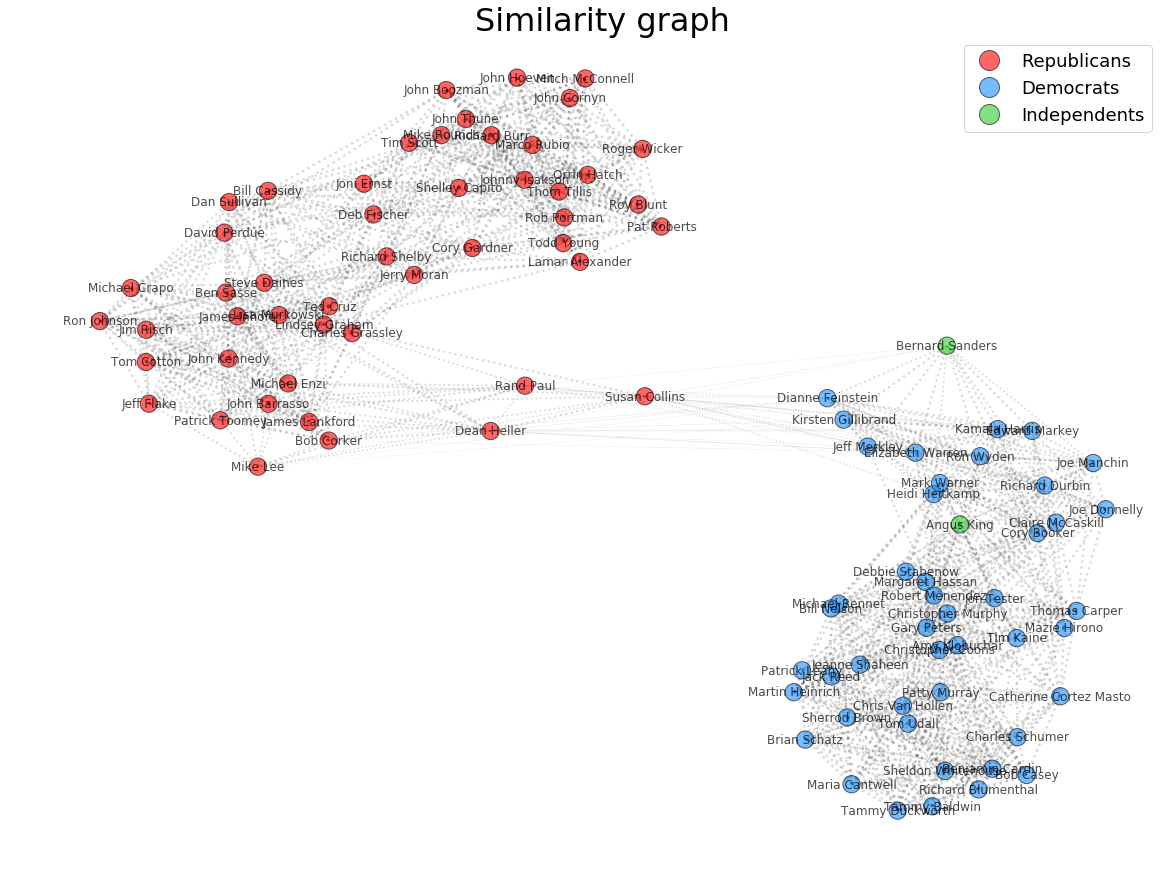

In [29]:
plot_signal(G_full.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1])
r = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
d = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
i = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[r,d,i], prop={'size':18})
plt.savefig("similarity_graph.png")
plt.title('Similarity graph', fontsize=32)

## Voting recommandation system

Our first research question is to find whether we can use a similarity graph to identify the senators which are the closest to our own political opinions and if so, where do our opinions lie in the political continuum ? To do so, we need to collect a few vote samples where we indicate how we would have voted if we were to be a senator.

However, giving our opinion of every vote cast in the senate would be highly impractical. Therefore, we need to chose carefully the votes which will convey the highest information on our political stance.

To this end, we build a similarity graph where nodes correspond to roll calls and features to senators. This will hopefully help us distinguish subjects based on their "electoral basis". We finish by selecting the best representative among each category of vote.